In [5]:
# 사용 가능한 GPU 확인
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

# GPU 사용 설정
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4247657148892431989
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6180007936
locality {
  bus_id: 1
  links {
  }
}
incarnation: 104485799454536034
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [6]:
# pip3 install tensorflow
from tensorflow.keras.layers import Conv2D, Dropout, Flatten, Dense
from tensorflow.keras import Input, Sequential
import numpy as np

# pip3 uninstall keras
# pip3 uninstall tensorflow
# pip3 install tensorflow --user

# ------------------------------------------------

# 객체 순회 및 작업 진행률 표시
# pip3 install tqdm
from tqdm import tqdm

# 이미지 프로세싱
# pip3 install opencv-python
import cv2

# 이미지 로드 시 옵션 설정
# pip3 install pillow
from PIL import ImageFile

# 데이터 시각화
# pip3 install matplotlib
import matplotlib.pyplot as plt

# ------------------------------------------------

# 디렉토리 접근
import sys

sys.path.append(os.path.join(os.getcwd(), os.path.pardir, 'functions'))

# from 파일명 import 함수명
from get_train_list import get_train_image_paths_and_encoding_labels_fn
from predict_and_test import get_predict_result_fn, get_test_csv_fn
from get_img_tensor import get_tensor_through_imgs_fn

# pip3 install scikit-learn
from sklearn.model_selection import train_test_split
from datetime import datetime

In [7]:
# ========== 특정 파일 1개 불러와서 표시하기 ==========

# img_path = 'open/test/000.png'
# plt.imshow(imread(img_path))
# plt.show()

# ===================================================

In [8]:
# ======== 학습용 이미지 경로와 라벨에 대한 각각의 리스트 생성하기 ========

train_image_paths, encoding_labels = get_train_image_paths_and_encoding_labels_fn()

# =====================================================================

encoding_labels.shape : (3457, 19)


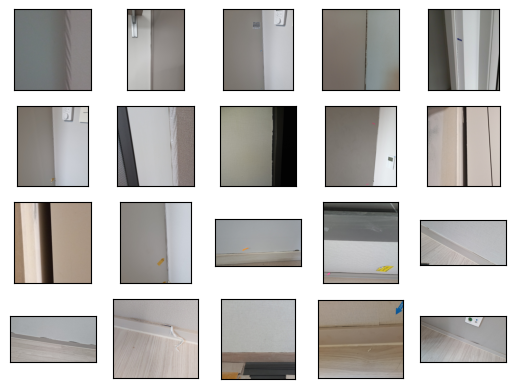

In [9]:
# ========= 학습용 이미지 리스트에서 20개만 확인해보기 =========

fig = plt.figure()

# 한글 폰트 설정
plt.rc('font', family='Malgun Gothic')

for index in range(20):

    ax = fig.add_subplot(4, 5, index + 1, xticks=[], yticks=[])
    img_path = train_image_paths[index]

    # img_name = [*os.path.split(img_path)].pop()
    # defect_type = encoding_labels[index]

    # 하자 유형_이미지 파일명.확장자
    # title = f'{defect_type}_{img_name}'
    # print('title :', title)

    # ax.set_title(title, fontsize=6)

    # issue: None
    # cause: 경로에 한글이 포함될 경우 발생함
    # img = cv2.imread(img_path)

    # solved
    img_array = np.fromfile(img_path, np.uint8)
    img = cv2.imdecode(img_array, cv2.IMREAD_UNCHANGED)

    # error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'
    # solved: img 유무 확인하기
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# ============================================================


In [10]:
# ========= 교수님 코드 따라서 이미지 데이터를 가져오고 차원 변형하기 =========

# 잘린 이미지에 대한 로드 여부 설정
ImageFile.LOAD_TRUNCATED_IMAGES = True

RESIZED_WIDTH = 100
RESIZED_HEIGHT = 100

fig = plt.figure()

train_image_tensor = get_tensor_through_imgs_fn(train_image_paths, RESIZED_HEIGHT, RESIZED_WIDTH, fig)
print('train_image_tensor.shape :', train_image_tensor.shape)

# ==========================================================================


  0%|          | 0/3457 [00:00<?, ?it/s]

In [ ]:
# ======== 교수님의 donkey_car_CNN 코드 따라서 학습시키기 ========

# 데이콘 리더 보드 점수 => 0.299285797%

EPOCHS = 40

# 학습 시킬 이미지 데이터에 대하여 정규화 (0 ~ 1)
normalized_train_image_tensor = train_image_tensor / 255
print('normalized_train_image_tensor.shape :',
      normalized_train_image_tensor.shape)

# 9:1 비율로 학습 시 사용할 데이터와 추론 시 사용할 데이터로 분리하고 랜덤성 부여
# x_for_train, x_test, y_for_train, y_test = train_test_split(
#     normalized_image_tensor, encoding_labels, test_size=0.1)

# 9:1 비율로 학습용 데이터와 검증용 데이터로 분리
# train_data_count = int(len(x_for_train) * 0.9)
# x_valid, y_valid = x_for_train[train_data_count:], y_for_train[train_data_count:]
# x_train, y_train = x_for_train[:train_data_count], y_for_train[:train_data_count]

# train 폴더 내의 모든 이미지 데이터에 대하여 학습 진행 (1개는 학습 중에 검증용 데이터로 사용)
x_train, x_valid, y_train, y_valid = train_test_split(
    normalized_train_image_tensor, encoding_labels, test_size=1)

model = Sequential([
    Input(shape=(RESIZED_WIDTH, RESIZED_HEIGHT, 3)),
    Conv2D(24, (5, 5), strides=(
        2, 2), padding='same', activation='relu'),
    Dropout(0.2),
    Conv2D(32, (5, 5), strides=(
        2, 2), padding='same', activation='relu'),
    Dropout(0.2),
    Conv2D(64, (5, 5), strides=(
        2, 2), padding='same', activation='relu'),
    Dropout(0.2),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    Dropout(0.2),
    Conv2D(64, (3, 3), activation='relu'),
    Dropout(0.2),
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dropout(0.2),
    Dense(19, activation='softmax'),
])

model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['acc'])

print('x_train.shape :', x_train.shape)
print('y_train.shape :', y_train.shape)

history = model.fit(x_train, y_train, epochs=EPOCHS,
                    validation_data=(x_valid, y_valid))

# 연월일_시간
now = datetime.today().strftime('%Y%m%d_%H%M%S')
model.save(f'model_{now}.h5')

# =============================================


normalized_train_image_tensor.shape : (3457, 100, 100, 3)
x_train.shape : (3456, 100, 100, 3)
y_train.shape : (3456, 19)
Epoch 1/40
108/108 [==============================] - 4s 10ms/step - loss: 2.2455 - acc: 0.3814 - val_loss: 2.5230 - val_acc: 0.0000e+00
Epoch 2/40
108/108 [==============================] - 1s 8ms/step - loss: 2.0542 - acc: 0.4036 - val_loss: 2.2624 - val_acc: 0.0000e+00
Epoch 3/40
108/108 [==============================] - 1s 7ms/step - loss: 1.9998 - acc: 0.4048 - val_loss: 2.5366 - val_acc: 0.0000e+00
Epoch 4/40
108/108 [==============================] - 1s 7ms/step - loss: 1.9255 - acc: 0.4065 - val_loss: 1.6791 - val_acc: 0.0000e+00
Epoch 5/40
108/108 [==============================] - 1s 7ms/step - loss: 1.8686 - acc: 0.4164 - val_loss: 1.4487 - val_acc: 0.0000e+00
Epoch 6/40
108/108 [==============================] - 1s 7ms/step - loss: 1.8129 - acc: 0.4326 - val_loss: 1.2018 - val_acc: 1.0000
Epoch 7/40
108/108 [==============================] - 1s 7ms/step 

loss : [2.245500087738037, 2.05424165725708, 1.9997988939285278, 1.925472378730774, 1.8686025142669678, 1.8128736019134521, 1.7587745189666748, 1.6791197061538696, 1.6309677362442017, 1.5910931825637817, 1.5322684049606323, 1.4458115100860596, 1.382994294166565, 1.3151817321777344, 1.2713338136672974, 1.1606639623641968, 1.1318302154541016, 1.061260461807251, 0.9846615195274353, 0.9242033362388611, 0.8871142268180847, 0.8114869594573975, 0.8187980055809021, 0.7742578983306885, 0.6926909685134888, 0.6542044878005981, 0.6252838373184204, 0.6162204146385193, 0.5933234095573425, 0.5530788898468018, 0.5407103300094604, 0.5001153945922852, 0.497016578912735, 0.4907474219799042, 0.46933212876319885, 0.4276646375656128, 0.39730149507522583, 0.38471004366874695, 0.3578507900238037, 0.36655357480049133]


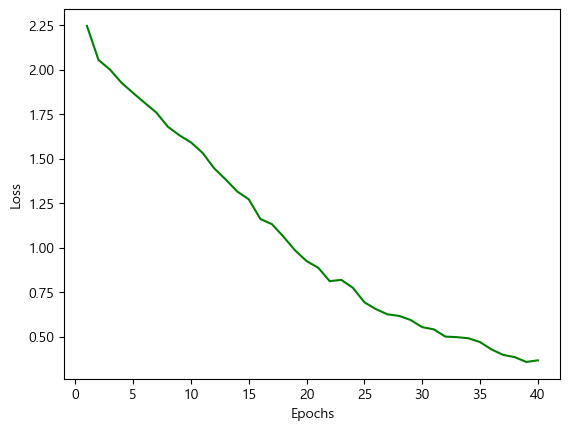

In [ ]:
# ======= 학습 횟수에 따른 오차 변화 그래프 =======

loss = history.history['loss']
print('loss :', loss)

plt.plot(range(1, EPOCHS + 1), loss, 'g')
plt.title = 'Tranning Loss'
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# ===============================================

  0%|          | 0/792 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 2/792 [00:00<00:56, 13.94it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|██████████| 792/792 [00:13<00:00, 60.64it/s]


normalized_test_image_tensor.shape : (792, 100, 100, 3)
25/25 [==============================] - 0s 10ms/step
predicted_y.shape : (792, 19)
predicted_labels : ['훼손', '오염', '오염', '오염', '훼손', '훼손', '오염', '훼손', '훼손', '오타공', '훼손', '오타공', '훼손', '훼손', '훼손', '터짐', '훼손', '훼손', '훼손', '훼손', '창틀,문틀수정', '훼손', '훼손', '오염', '오염', '훼손', '석고수정', '오염', '훼손', '훼손', '오염', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '석고수정', '훼손', '꼬임', '오염', '들뜸', '훼손', '오염', '오염', '훼손', '오염', '훼손', '석고수정', '오염', '오염', '오타공', '훼손', '훼손', '오염', '훼손', '훼손', '훼손', '오타공', '오타공', '걸레받이수정', '훼손', '훼손', '훼손', '훼손', '걸레받이수정', '훼손', '걸레받이수정', '훼손', '걸레받이수정', '훼손', '훼손', '오타공', '훼손', '훼손', '훼손', '훼손', '오타공', '오염', '훼손', '오염', '오타공', '훼손', '훼손', '꼬임', '훼손', '훼손', '걸레받이수정', '오염', '오염', '훼손', '훼손', '훼손', '오염', '터짐', '오타공', '훼손', '훼손', '걸레받이수정', '훼손', '훼손', '터짐', '훼손', '오염', '오염', '훼손', '훼손', '오염', '오염', '오타공', '훼손', '오염', '훼손', '훼손', '훼손', '오염', '녹오염', '훼손', '훼손', '훼손', '오염', '녹오염', '훼손', '훼손', '훼손', '훼손', '오염', '걸레받이수정', '훼손', '오염

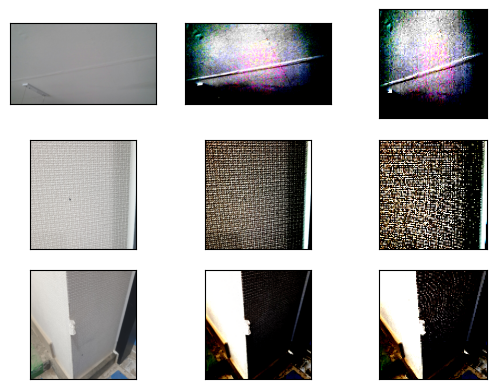

In [ ]:
# ================== 테스트 파일로 추론해보기 ==================

predict_result = get_predict_result_fn(RESIZED_WIDTH, RESIZED_HEIGHT, model)
get_test_csv_fn(predict_result)

# ============================================================